
This tutorial proposes a way of analyzing an image of a drop on a SLIPS surface.
At the end of it, we will have gathered the important characteristics of the drop:

- its edge
- its base radius
- the position of the triple (oil-drop-vapor) point
- the apparent contact angles

## Installing the needed packages

### Basic packages
During this tutorial, we will need several python packages that has to be installed on your environment.
The majority of the needed packages can be installed from [PyPI](https://pypi.python.org/pypi) using the following command:

```sh
pip install imageio matplotlib numpy scipy
```

Or for conda users:

```sh
conda install imageio matplotlib numpy scipy
```

### OpenCV
We will also need [OpenCV](https://opencv.org) to be installed.
For conda users on windows, you should be able to get this working with the following command:

```sh
conda install opencv

```

Or this one:
```sh
conda install -c menpo opencv
```

For Linux users, get OpenCV from your distribution repository or build it from [source](https://opencv.org/releases.html).

## Importing images
[Imageio](http://imageio.readthedocs.io/en/latest/index.html) package allows to import and export a variety of image formats (see [here](http://imageio.readthedocs.io/en/latest/formats.html) for an exhaustive list).

Imageio can also import videos or grab images directly from cameras.

In [1]:
import imageio
image = imageio.imread('data/image.bmp')

{{%expand "Explain me this block" %}}
We first imports the Imageio module.  
Then use its `imread()` function to read the image and store it in the `image` variable.
{{% /expand%}}

Images are stored as arrays of numbers.
We can display them using the [matplotlib](https://matplotlib.org/) package:

In [2]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.show()

<Figure size 640x480 with 2 Axes>

{{%expand "Explain me this block" %}}
We first imports the `pyplot` submodule from matplotlib.
The `Pyplot` module is the main submodule for plotting data in a Matlab-way.   
We then create a figure with `plt.figure()`, display the image in it with `plt.imshow()`, add a colorbar with `plt.colorbar()` and show the results with `plt.show()`.   
Depending on your IDE, you may not need the last line, as the figures will automatically be shown.
{{% /expand%}}

## Cropping


The drop is centered on the image, but a part of the syringe that was used to drop it is also visible at the top.

An edge detection performed directly on this image will certainly detect the syringe edges.
To avoid that, we will restrain the area of interest around the drop.

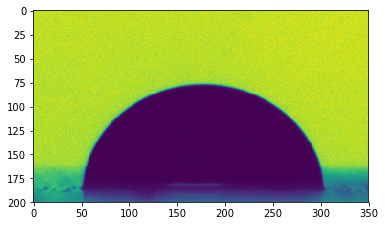

In [3]:
image = image[200:400, 200:550]

# Display
plt.figure()
plt.imshow(image)
plt.show()
              

{{%expand "Explain me this block" %}}
The `image` variable is an array of numbers that can be cropped using indexes. 
It is here cropped from indexes 200 to 550 on the x axis and from indexes 200 to 400 on the y axis.
Because of the way images are referenced by the Imageio and matplotlib packages, the y axis has to be specified first.  
We then display the image.
{{% /expand%}}

## Edge detection
[OpenCV](https://opencv.org/) (Open Source Computer Vision Library) is a well-known library for image analysis that provides a Python interface.
We will use one of its edge detection functions to get the edge of our drop.
More specifically, we will use the [Canny edge detector](https://en.wikipedia.org/wiki/Canny_edge_detector).

This edge detector method necessitates to specify two threshold values, that have to be optimized depending on the nature/quality of the edges to detect.
A first good guess is generally to take the minimal and maximal pixel values as thresholds.

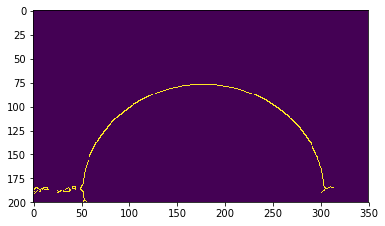

In [4]:
import cv2
thres1 = image.min()
thres2 = image.max()
edges = cv2.Canny(image, thres1, thres2)

# Display the edges
plt.figure()
plt.imshow(edges)
plt.show()

{{%expand "Explain me this block" %}}
We import opencv with `import cv2`.  
Minimal and maximal pixel values are obtained using the `min()` and `max()` methods and stored.  
Those values are then used as arguments of the OpenCV edge detector: `Canny()`.  
The result is an array of numbers, stored in the `edges` variable.   
This array of numbers id finally displayed.
{{% /expand%}}

The `Canny()` function returns an array of numbers that is equal to 1 (in yellow here) where edges have been detected, and 0 (in blue here) elsewhere.

OpenCV successfully detects the drop edges, but also some structures near the sample surface.
Lets improve the threshold values to get rid of those unwanted bits.

{{%alert info%}} Some methods, like the [Otsu method](https://en.wikipedia.org/wiki/Otsu%27s_method), can be used to automatically infers good threshold values from an image. {{% /alert %}} 


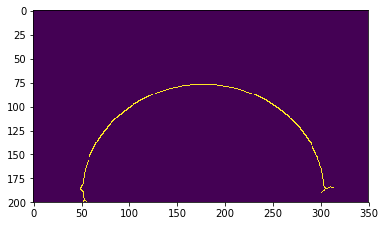

In [5]:
thres1 = image.min()*0.75
thres2 = image.max()*1.5
edges = cv2.Canny(image, thres1, thres2)

# Display the edges
plt.figure()
plt.imshow(edges)
plt.show()

{{%expand "Explain me this block" %}}
This block is mainly similar to the previous one.  
The threshold values are just adjusted to get rid of the unwanted edges near the sample surface.
The thresholds values are now 0.75 times the minimal pixel value and 1.5 times the maximal pixel value.
{{% /expand%}}

We got rid of some of the unwanted bits, but we still detect some weird shapes due to the reflection of the drop on the sample (around x=50, y=200 for example).
We can remove them by deleting all the edges detected below the baseline, that is here roughly y=180.

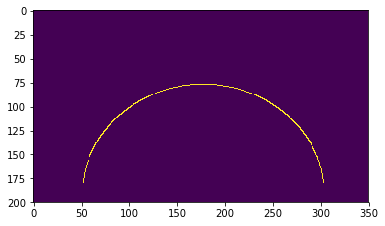

In [6]:
edges[180:, :] = 0

# Display the edges
plt.figure()
plt.imshow(edges)
plt.show()

{{%expand "Explain me this block" %}}
`edges` is an array containing 1 where edges were detected and 0 elsewhere.
To remove edges for y<180, we just need to fill the array with 0 for y<180.  
This is done by specifying that the values of `edges` from y=180 to infinity (`180:`) and for every x (`:`) are set to 0.
{{% /expand%}}

## From image to points
Our drop edge is for the moment stored as an array of 0 and 1.
If we want to access the edge coordinates, we need to find the positions of each pixel equal to 1 (yellow pixels here).

The [numpy](http://www.numpy.org/) package can help us do that by detecting where the pixel values are not zero.

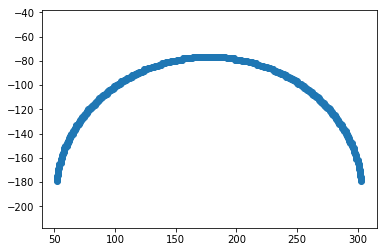

In [7]:
import numpy as np
ys, xs = np.where(edges)
ys = np.asarray(-ys, dtype=float)
xs = np.asarray(xs, dtype=float)

# Display the edges
plt.figure()
plt.plot(xs, ys, marker='o', ls='none')
plt.axis('equal')
plt.show()

{{%expand "Explain me this block" %}}
We import numpy with `import numpy as np`.  
The `np.where()` function returns the positions of the array that are not equal to zero. 
Which are here the positions of our drop edge.  
The two following lines allow to transform the position from integers to floating point values.
This will be needed for the next steps.  
`plt.plot()` allows to plot the edge points position.  
`plt.axis('equal')` ensures that the image is not deformed (stretched) along x or y.
{{% /expand%}}

For convenience, we want to center the drop on the referential.

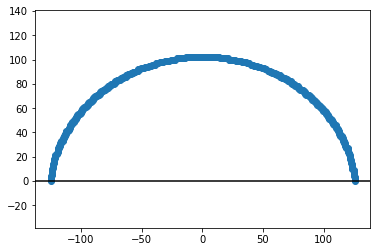

In [8]:
xs = xs - xs.mean()
ys = ys - ys.min()

# Plot the edges
plt.figure()
plt.plot(xs, ys, marker='o', ls='none')
plt.axhline(0, color='k')
plt.axis('equal')
plt.show()

{{%expand "Explain me this block" %}}
`xs.mean()` allows to access the average position of the edges along x.  
`ys.min()` allows to access the minimal position of the edges along y.  
By substracting those values to x and y, we ensure that the origin of our referential is at the base of the drop.
{{% /expand%}}

## From pixels to mm

We achieved to get the edge coordinated in pixel.
To pass this information into millimeters, we need to know the ratio between pixels and mm for our base image.

It can be done by measuring the syringe diameter (here ~60 pixels) that we know is about 0.5mm.
This gives us a resolution of 120px/mm.

We can now scale our edge coordinates:

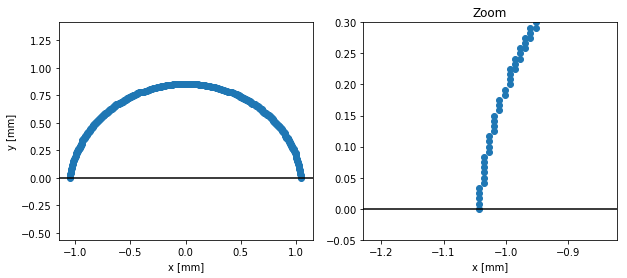

In [9]:
res = 120 
xs /= res
ys /= res

# Plot the edge
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(axs[0])
plt.plot(xs, ys, marker='o', ls='none')
plt.axhline(0, color='k')
plt.axis('equal')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
# Plot a zoom on the edge
plt.sca(axs[1])
plt.plot(xs, ys, marker='o', ls='none')
plt.axhline(0, color='k')
plt.axis('equal')
plt.xlabel('x [mm]')
plt.xlim(-1.15, -0.9)
plt.ylim(-0.05, 0.3)
plt.title("Zoom")
plt.show()

## Fitting the edge

Problem with the edge coordinates we obtained at this point is that they are at discrete positions (because extracted from an image).
It is impossible to obtain contact angles or triple point position from this kind of discretized data.
In order to go further, we need to find a good fitting of the drop edge.

The [Scipy](https://www.scipy.org/) package provides several ways of fitting different kind of data.
Here, as we don't care about the mathematical expression of our fitting, we will use a spline fitting: `UnivariateSpline`.

This fitting function needs the data to be sorted and with strictly increasing x values.
Our edge coordinated need some transformation to fit those specifications.

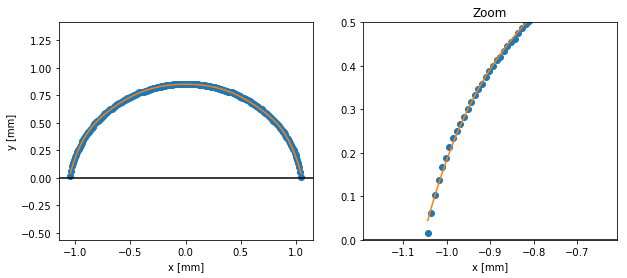

In [10]:
# Ensure increasing x values
new_xs = np.sort(list(set(xs)))
new_ys = []
for x in new_xs:
    new_ys.append(np.mean(ys[xs == x]))
xs = new_xs
ys = np.asarray(new_ys)

# Fitting the drop edge
import scipy.interpolate as spint
edge_f = spint.UnivariateSpline(xs, ys, k=5, s=0.005)

# Display the fit
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(axs[0])
plt.plot(xs, ys, marker='o', ls='none')
plt.plot(xs, edge_f(xs))
plt.axhline(0, color='k')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.axis('equal')
# Plot a zoom on the edge
plt.sca(axs[1])
plt.plot(xs, ys, marker='o', ls='none')
plt.plot(xs, edge_f(xs))
plt.axhline(0, color='k')
plt.axis('equal')
plt.xlabel('x [mm]')
plt.xlim(-1.1, -0.7)
plt.ylim(0, 0.5)
plt.title("Zoom")
plt.show()

{{%expand "Explain me this block" %}}
We first sort the drop edges position along x and put them in the `new_xs` variable.  
Then, for each value of x, we average the associated values of y, to ensure that there is only one value of y for each x.  
We then perform the fitting using the `UnivariateSpline` function from Scipy.  
`k` and `s` parameters can be tuned to achieve smoother or more accurate fitting.  
We then display the edge and its fitting.
{{% /expand%}}

## Getting the drop basic properties

We can now extract some information from our data, like the drop base length or the drop height:

In [11]:
base_radius = xs.max() - xs.min()
height = ys.max()

# Print
print("Drop base: {} mm".format(base_radius))
print("Drop height: {} mm".format(height))

Drop base: 2.091666666666667 mm
Drop height: 0.85 mm


## Getting the contact angles

The contact angles are the angles made by our fitted curve and the baseline (here `y=0`).


74.74264462928066
105.21597243751776


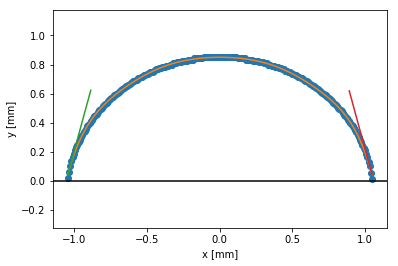

In [12]:
# Get left and right contact points
left_x = np.min(xs)
right_x = np.max(xs)
dx = (right_x - left_x)/100

# Left angle
import scipy.misc as spmisc
deriv = spmisc.derivative(edge_f, left_x, dx=dx)
theta_left =  np.arctan(deriv)

# Right angle
deriv = spmisc.derivative(edge_f, right_x, dx=dx)
theta_right = np.pi + np.arctan(deriv)

# Print
print(theta_left/np.pi*180)
print(theta_right/np.pi*180)

# Display the fit and the angles
plt.figure()
plt.plot(xs, ys, marker='o', ls='none')
plt.plot(xs, edge_f(xs))
plt.axhline(0, color='k')
angle_len = .6
plt.plot([left_x, left_x + angle_len*np.cos(theta_left)],
         [edge_f(left_x), edge_f(left_x) + angle_len*np.sin(theta_left)])
plt.plot([right_x, right_x + angle_len*np.cos(theta_right)],
         [edge_f(right_x), edge_f(right_x) + angle_len*np.sin(theta_right)])
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.axis('equal')
plt.show()

{{%expand "Explain me this block" %}}
We first determine the positions of the drop edge contact with the baseline along x.  
We then use the `derivative` function from Scipy to get the edge local slope at each contacts using our fitting.  
`dx` is used by the derivation algorithm. you can use a smaller value to get a more accurate result.  
The edge local gradients are then translated to angles.  
We then print and display the contact angles.
{{% /expand%}}

## Getting the triple point

Coming soon...